# **Environment Setup**

In [1]:
pip install -r requirements.txt

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached certifi-2024.2.2-py3-none-any.whl.metadata (2.2 kB)
  Using cached charset_normalizer-3.3.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (33 kB)
  Using cached contourpy-1.2.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached fonttools-4.50.0-cp310-cp310-macosx_10_9_universal2.whl.metadata (159 kB)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached grpcio-1.62.1-cp310-cp310-macosx_12_0_universal2.whl.metadata (4.0 kB)
  Using cached h5py-3.10.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.5 kB)
  Using cached idna-3.6-py3-non

In [3]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import warnings
import pydot
import graphviz
import random
 
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score
from tqdm import tqdm

In [47]:
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
random.seed(42)

# **Data Loading**

In [7]:
cx_data_train_path = "data/chest_xray/train"
cx_data_val_path = "data/chest_xray/val"
cx_data_test_path = "data/chest_xray/test"

In [8]:
images_norm_train = [file for file in os.listdir(f'{cx_data_train_path}/NORMAL') if file.endswith('.jpeg')]
images_pneum_train = [file for file in os.listdir(f'{cx_data_train_path}/PNEUMONIA') if file.endswith('.jpeg')]
random.shuffle(images_norm_train)
random.shuffle(images_pneum_train)

images_norm_val = [file for file in os.listdir(f'{cx_data_val_path}/NORMAL') if file.endswith('.jpeg')]
images_pneum_val = [file for file in os.listdir(f'{cx_data_val_path}/PNEUMONIA') if file.endswith('.jpeg')]

images_norm_test = [file for file in os.listdir(f'{cx_data_test_path}/NORMAL') if file.endswith('.jpeg')]
images_pneum_test = [file for file in os.listdir(f'{cx_data_test_path}/PNEUMONIA') if file.endswith('.jpeg')]

# **Data Exploration**

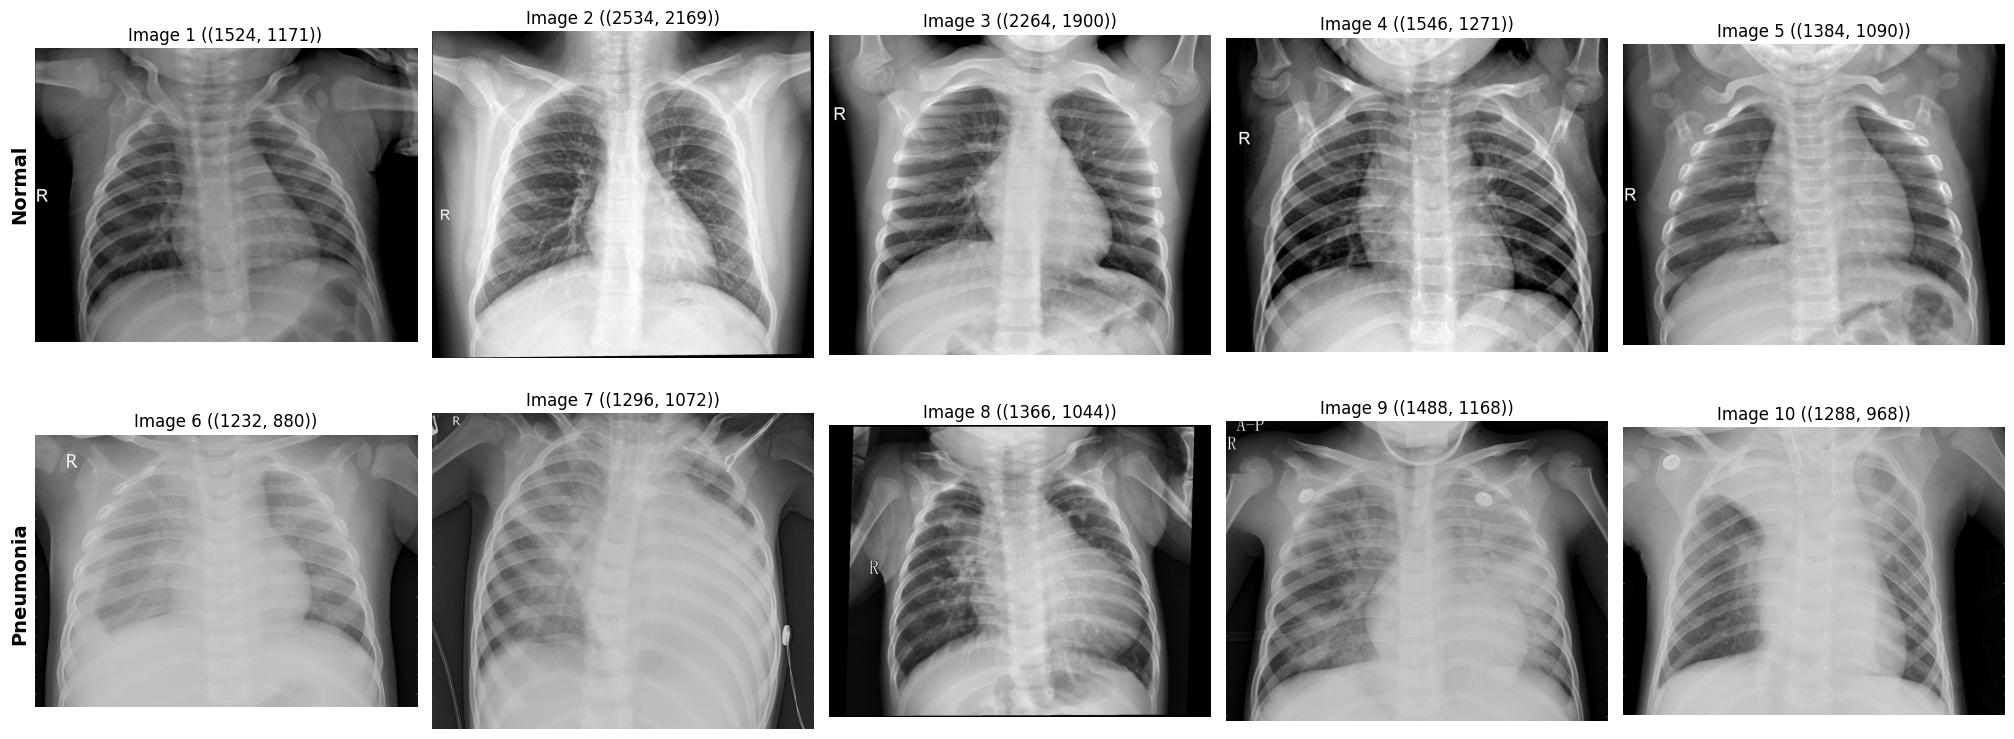

In [216]:
n = 5

fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(20, 8))

# Plot the images
for i, (image_name, ax) in enumerate(zip(images_norm_train[:n], axes[0])):
    image_path = os.path.join(cx_data_train_path, 'NORMAL', image_name)
    image = Image.open(image_path)

    ax.imshow(image, cmap="gray")
    ax.set_title(f'Image {i+1} ({image.size})')
    ax.axis('off')

for i, (image_name, ax) in enumerate(zip(images_pneum_train[:n], axes[1])):
    image_path = os.path.join(cx_data_train_path, 'PNEUMONIA', image_name)
    image = Image.open(image_path)

    ax.imshow(image, cmap="gray")
    ax.set_title(f'Image {i+n+1} ({image.size})')
    ax.axis('off')

for i, row_label in enumerate(reversed(['Normal', 'Pneumonia'])):
    fig.text(0, (i+0.5)/2, row_label, ha='center', va='center', fontsize=14, fontweight='bold', rotation='vertical')

plt.tight_layout()
plt.show()

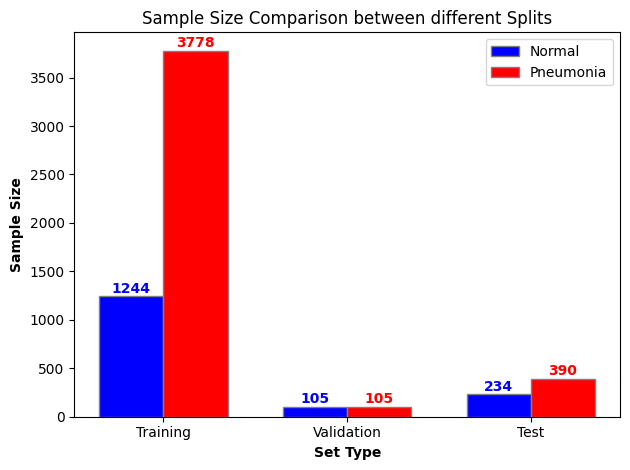

In [10]:
models = ['Training', 'Validation','Test']
norm_count = [len(images_norm_train), len(images_norm_val), len(images_norm_test)]
pneum_count = [len(images_pneum_train), len(images_pneum_val), len(images_pneum_test)]

bar_width = 0.35

r1 = range(len(models))
r2 = [x + bar_width for x in r1]

bars_n = plt.bar(r1, norm_count, color='b', width=bar_width, edgecolor='grey', label='Normal')
bars_p = plt.bar(r2, pneum_count, color='r', width=bar_width, edgecolor='grey', label='Pneumonia')

plt.xlabel('Set Type', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)
plt.ylabel('Sample Size', fontweight='bold')
plt.title('Sample Size Comparison between different Splits')
plt.legend()

for bar in bars_n:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval+5, round(yval, 2), va='bottom', color='b', weight="bold", horizontalalignment='center')

for bar in bars_p:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval+5, round(yval, 2), va='bottom', color='r', weight="bold", horizontalalignment='center')

plt.tight_layout()
plt.show()

# **Preprocessing**

In [181]:
norm = 255.0
rescale=1./norm
shear_range=0.2
zoom_range=0.2
horizontal_flip=False

image_height, image_width = 240, 240
target_size=(image_height, image_width)
batch_size=32
class_mode='binary'

In [182]:
train_datagen = ImageDataGenerator(
        rescale=rescale,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
)

validation_datagen = ImageDataGenerator(rescale=rescale)

test_datagen = ImageDataGenerator(rescale=rescale)

train_generator = train_datagen.flow_from_directory(
    cx_data_train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
)

validation_generator = validation_datagen.flow_from_directory(
    cx_data_val_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode,
)

test_generator = test_datagen.flow_from_directory(
    cx_data_test_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode
)

Found 5022 images belonging to 2 classes.
Found 210 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


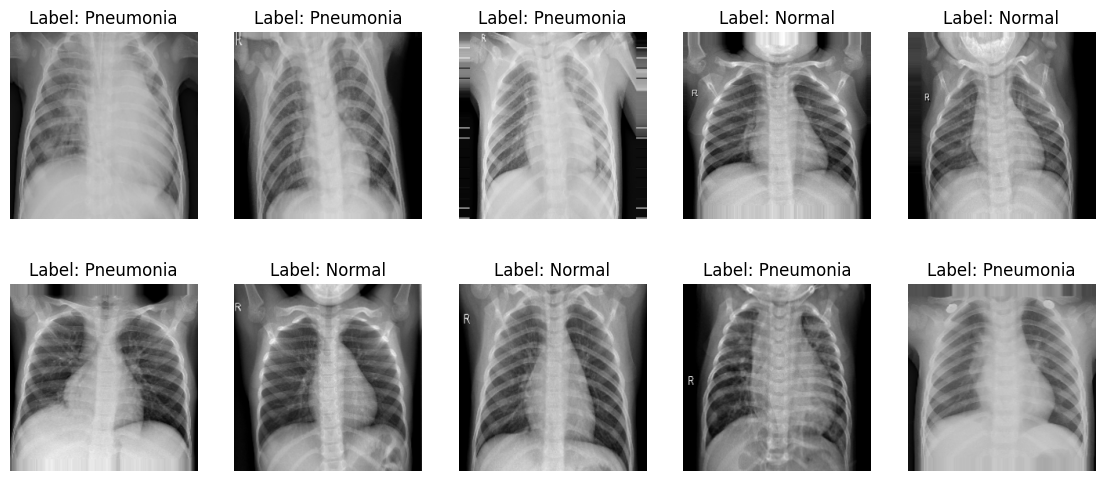

In [183]:
rows = 2
cols = 5

fig, axes = plt.subplots(rows, cols, figsize=(14, 3*rows))
for i in range(rows):
    for j in range(cols):
        # Get the next batch of data
        inputs, label_index = next(train_generator)
        label = "Normal" if label_index[0] == 0 else "Pneumonia"
    
        # Plot the first image from the batch
        axes[i,j].imshow(inputs[0])
        axes[i,j].set_title(f"Label: {label}")  # Set the title to the corresponding label
        axes[i,j].axis('off')

# Show the plot
plt.show()

# **CNN Model**

In [184]:
if 'GPU' in [tf.config.list_physical_devices('GPU')[i].device_type for i in range(len(tf.config.list_physical_devices('GPU')))]:
    print("GPU is available")
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU'), 'GPU')
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("GPU is not available")

GPU is available


In [185]:
model = tf.keras.models.Sequential([
    layers.Input(shape=(image_height, image_width, 3)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.BatchNormalization(axis=1),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.BatchNormalization(axis=1),
    layers.Conv2D(16, (3, 3), activation='relu', name='last_conv_layer'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.BatchNormalization(axis=1),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])
model.build()
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_47 (Conv2D)              │ (None, 240, 240, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 120, 120, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 120, 120, 256)  │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 118, 118, 64)   │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 59, 59, 64)     │           236 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv_layer (Conv2D)        │ (None, 57, 57, 16)     │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 29, 29, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 29, 29, 16)     │           116 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 512)            │     6,889,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,120,529 (27.16 MB)

 Trainable params: 7,120,113 (27.16 MB)

 Non-trainable params: 416 (1.62 KB)

In [186]:
checkpoint_filepath = 'model/ckpt/checkpoint.model.keras'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss', 
    mode='auto',             
    save_best_only=True     
)

In [187]:
loss='binary_crossentropy'
metrics=['accuracy']
epochs = 20

In [188]:
tf.keras.utils.set_random_seed(42)
model.compile(optimizer='adam', loss=loss, metrics=metrics)

tf.keras.utils.set_random_seed(42)
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback]
)
model.save('model/cnn.keras')

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 465ms/step - accuracy: 0.6415 - loss: 2.1169 - val_accuracy: 0.5000 - val_loss: 0.8109
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 462ms/step - accuracy: 0.7391 - loss: 0.4976 - val_accuracy: 0.6000 - val_loss: 0.5707
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 458ms/step - accuracy: 0.8342 - loss: 0.3521 - val_accuracy: 0.7714 - val_loss: 0.4542
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 462ms/step - accuracy: 0.8576 - loss: 0.3333 - val_accuracy: 0.8333 - val_loss: 0.4479
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 457ms/step - accuracy: 0.8945 - loss: 0.2661 - val_accuracy: 0.8429 - val_loss: 0.4179
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 455ms/step - accuracy: 0.8981 - loss: 0.2615 - val_accuracy: 0.9429 - val_loss: 0.1762
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 455ms/step - accuracy: 0.9126 - loss: 0.2276 - val_accuracy: 0.7762 - val_loss: 0.4773
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 457ms/step - accuracy: 0.9019 - loss: 0

In [189]:
model.load_weights(checkpoint_filepath)

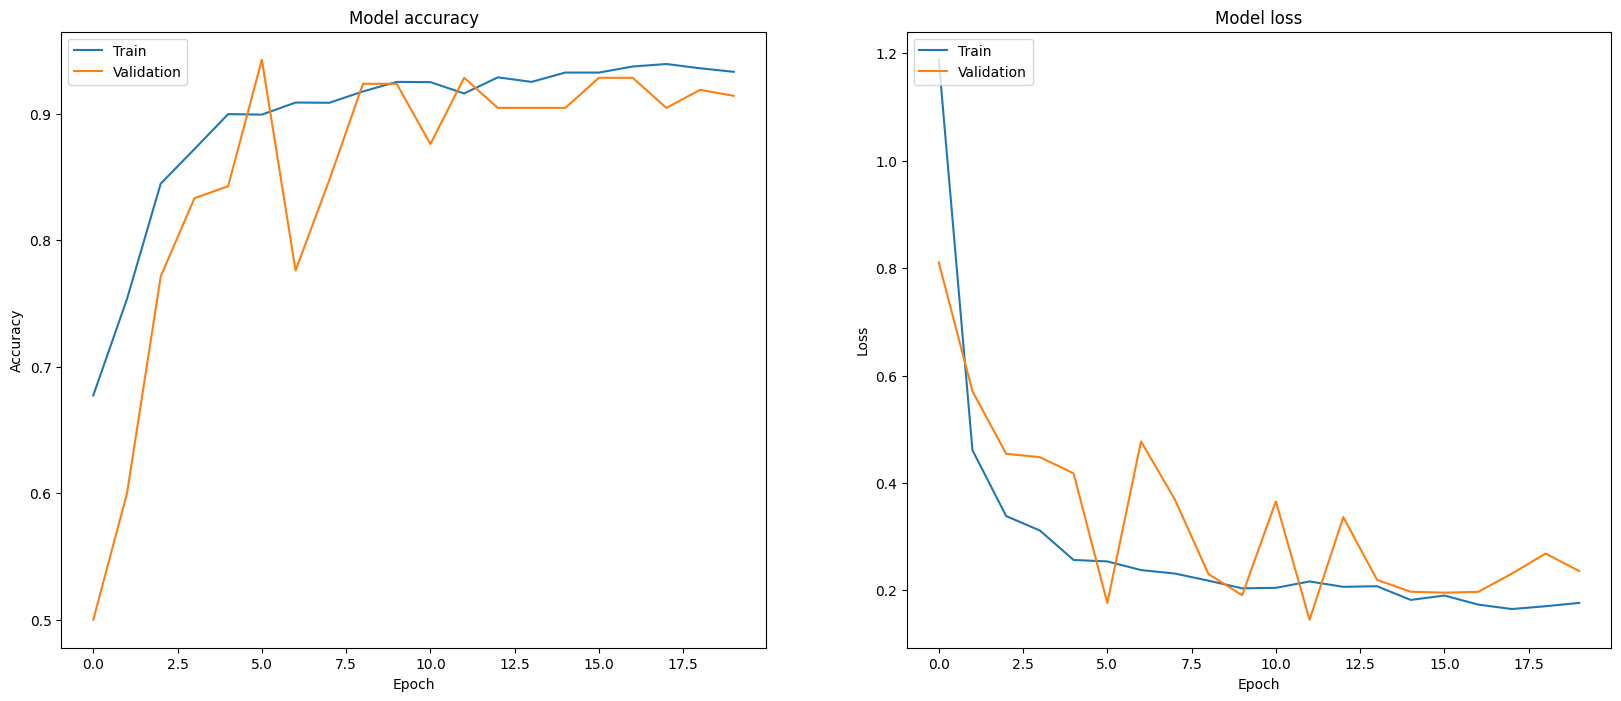

In [190]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')  # Fixed: Use set_title instead of title
axes[0].set_xlabel('Epoch')  # Fixed: Use set_xlabel instead of xlabel
axes[0].set_ylabel('Accuracy')  # Fixed: Use set_ylabel instead of ylabel
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])  # Fixed: Use axes[1] for the second subplot
axes[1].plot(history.history['val_loss'])  # Fixed: Use axes[1] for the second subplot
axes[1].set_title('Model loss')  # Fixed: Use set_title instead of title
axes[1].set_xlabel('Epoch')  # Fixed: Use set_xlabel instead of xlabel
axes[1].set_ylabel('Loss')  # Fixed: Use set_ylabel instead of ylabel
axes[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [236]:
test_loss, test_accuracy = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.8993 - loss: 0.3111
Test Loss: 0.32603898644447327
Test Accuracy: 0.8894230723381042


In [264]:
predictions = []
true_labels = []

for images, labels in tqdm(test_generator):
   predictions.append(np.array(model.predict(images, verbose=False) > 0.5, dtype=int))
   true_labels.append(labels)

   if len(predictions) == len(test_generator):
       break

predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)

 95%|█████████▌| 19/20 [00:05<00:00,  3.20it/s]


In [266]:
balanced_accuracy = balanced_accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Balanced Accuracy: 0.8696581196581197
F1 Score: 0.9147095179233622


# **Integrated Gradients**

In [300]:
def integrated_gradients(image, target_label, baseline, model, steps=50):
  scaled_inputs = tf.stack([(baseline + (float(i)/steps)*(image-baseline)) for i in tf.range(0, steps+1)])
  _, grads = predictions_and_gradients(model, scaled_inputs, target_label)

  grads = (grads[:-1] + grads[1:]) / 2.0
  avg_grads = np.average(grads, axis=0)
  integrated_gradients = (image-baseline)*avg_grads
  return integrated_gradients

def predictions_and_gradients(model, inputs, label):
  with tf.GradientTape() as tape:
    tape.watch(inputs)
    predictions = model(inputs)
    predicted_probs = predictions if label == 1 else 1-predictions
    
  gradients = tape.gradient(predicted_probs, inputs)
  return predicted_probs, gradients

def normalize_image(image):
  min = tf.reduce_min((image))
  shifted_image = (image - min)
  max = tf.reduce_max((shifted_image))
  rescaled_image = shifted_image/max
  return rescaled_image

def plot_img_attributions(baseline, image, attribution_mask, label, predicted_label, alpha, dir_path=None, file_name=None):

    attribution_mask = tf.image.rgb_to_grayscale(attribution_mask)

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
    axes[0].imshow(baseline, cmap="gray")
    axes[0].set_title("Baseline")
    axes[0].axis('off')
    axes[1].imshow(image)
    axes[1].set_title("Original Image")
    axes[1].axis('off')
    axes[2].imshow(attribution_mask, cmap="viridis", interpolation='nearest')
    axes[2].set_title("Attribution Mask")
    axes[2].axis('off')
    axes[3].imshow(image)
    axes[3].imshow(attribution_mask,cmap="viridis", alpha=alpha)
    axes[3].set_title("Overlay")
    axes[3].axis('off')
    color = 'green' if label==predicted_label else 'red'
    fig.text(0.5, 0.8, f'Label: {label}', ha='center', va='center', fontsize=14, fontweight='bold')
    fig.text(0.5, 0.75, f'Predicted: {predicted_label}', ha='center', va='center', fontsize=14, fontweight='bold', color=color)

    plt.savefig(f'{dir_path}/{file_name}.png', bbox_inches='tight')
    plt.close()

### Black baseline image

In [301]:
alpha = 0.4
images, labels = test_generator[0]

for i, (image, label_index) in tqdm(enumerate(zip(images, labels))):
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    baseline_tensor = tf.zeros(image_tensor.shape)
    attribution_mask = integrated_gradients(image_tensor, int(label_index), baseline_tensor, model)
    attribution_mask = normalize_image(attribution_mask)
    label = "Normal" if label_index == 0 else "Pneumonia"
    prediction = model(tf.expand_dims(image, axis=0))
    predicted_label = "Normal" if prediction <= 0.5 else "Pneumonia"

    plot_img_attributions(baseline_tensor, image_tensor, attribution_mask, label, predicted_label, alpha=alpha, dir_path=f'figures/pt2/integrated_gradients1/black_baseline/{label}', file_name=f'ig_{i}')

32it [00:45,  1.43s/it]


### Uniform baseline image

In [302]:
alpha = 0.4
images, labels = test_generator[0]

for i, (image, label_index) in tqdm(enumerate(zip(images, labels))):
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    baseline_tensor = tf.repeat(tf.reshape(tf.random.uniform(image_tensor.shape[:-1]), (image_tensor.shape[0], image_tensor.shape[1], 1)), 3, axis=2)
    attribution_mask = integrated_gradients(image_tensor, int(label_index), baseline_tensor, model)
    attribution_mask = normalize_image(attribution_mask)
    label = "Normal" if label_index == 0 else "Pneumonia"
    prediction = model(tf.expand_dims(image, axis=0))
    predicted_label = "Normal" if prediction <= 0.5 else "Pneumonia"

    plot_img_attributions(baseline_tensor, image_tensor, attribution_mask, label, predicted_label, alpha=alpha, dir_path=f'figures/pt2/integrated_gradients/uniform_baseline/{label}', file_name=f'ig_{i}')

32it [00:44,  1.41s/it]


# **Grad-CAM**

In [306]:
def grad_cam(model, last_conv_layer_name, image_tensor):
    img_shape = tf.shape(image_tensor)
    img_height, img_width = int(img_shape[0]), int(img_shape[1])
    
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)
    
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    
    start_iteration = False
    for layer_name in model.layers:
        if layer_name == last_conv_layer_name:
            start_iteration = True
        if start_iteration:
            x = model.get_layer(layer_name)(x)
        
    classifier_model = tf.keras.Model(classifier_input, x)
    
    with tf.GradientTape() as tape:
        inputs = image_tensor[np.newaxis, ...]
        last_conv_layer_output = last_conv_layer_model(inputs)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])

        #top_class_channel = preds[:,top_pred_index]
        top_class_channel = tf.boolean_mask(preds, top_pred_index, axis=2)

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # Average over all the filters to get a single 2D array
    gradcam = np.mean(last_conv_layer_output, axis=-1)
    # Clip the values (equivalent to applying ReLU)
    # and then normalise the values
    gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
    gradcam = cv2.resize(gradcam, (img_height, img_width))
    
    return gradcam

def plot_gradcam(img_tensor, gradcam, label, predicted_label, alpha, dir_name, file_name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].imshow(img_tensor)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[1].imshow(img_tensor)
    axes[1].imshow(gradcam, alpha=alpha)
    axes[1].set_title("Grad-Cam")
    axes[1].axis('off')
    color = 'green' if label==predicted_label else 'red'
    fig.text(0,0.5, label, ha='center', va='center', fontsize=14, fontweight='bold', rotation='vertical')
    fig.text(0.03,0.5, predicted_label, ha='center', va='center', fontsize=14, fontweight='bold', rotation='vertical', color=color)
     
    plt.savefig(f'{dir_name}/{label}/{file_name}.png', bbox_inches='tight')

    plt.close()

In [307]:
alpha = 0.5
images, labels = test_generator[0]

for i, (image, label_index) in enumerate(zip(images[:n], labels[:n])):
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

    gradcam = grad_cam(model, "last_conv_layer", image_tensor)
    label = "Normal" if label_index == 0 else "Pneumonia"
    prediction = model(tf.expand_dims(image, axis=0))
    predicted_label = "Normal" if prediction <= 0.5 else "Pneumonia"
    plot_gradcam(image, gradcam, label, predicted_label, alpha, 'figures/pt2/gradcam', f'gradcam_{i}')

# **Data Randomization Test**

In [201]:
class PermutedDirectoryIterator(DirectoryIterator):
    def __init__(self, *args, permuted_labels=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.permuted_labels = permuted_labels

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = super()._get_batches_of_transformed_samples(index_array)
        batch_y = self.permuted_labels[index_array]

        return batch_x, batch_y

In [202]:
all_labels = []
for _ in range(len(train_generator)):
    _, labels = next(train_generator)  
    all_labels.append(labels)
all_labels = np.concatenate(all_labels)

permuted_labels = np.random.permutation(all_labels)

train_generator_permuted = PermutedDirectoryIterator(
    directory=cx_data_train_path,
    image_data_generator=train_datagen,
    permuted_labels=permuted_labels,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=class_mode
)

Found 5022 images belonging to 2 classes.


In [205]:
model_permuted = tf.keras.models.clone_model(model)

In [206]:
checkpoint_filepath_permuted = 'model_permuted/ckpt/checkpoint.model.keras'

checkpoint_callback_permuted = ModelCheckpoint(
    filepath=checkpoint_filepath_permuted,
    monitor='val_loss', 
    mode='auto',             
    save_best_only=True     
)

In [207]:
model_permuted.compile(optimizer='adam', loss=loss, metrics=metrics)
history_perm = model_permuted.fit(
    train_generator_permuted,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback_permuted]
)
model_permuted.save('model_permuted/cnn.keras')

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 472ms/step - accuracy: 0.6275 - loss: 1.7568 - val_accuracy: 0.5000 - val_loss: 1.1048
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 76s 463ms/step - accuracy: 0.7477 - loss: 0.6197 - val_accuracy: 0.5000 - val_loss: 0.8895
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 485ms/step - accuracy: 0.7521 - loss: 0.5631 - val_accuracy: 0.5000 - val_loss: 0.8387
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 496ms/step - accuracy: 0.7537 - loss: 0.5628 - val_accuracy: 0.5000 - val_loss: 0.8374
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 76s 469ms/step - accuracy: 0.7558 - loss: 0.5557 - val_accuracy: 0.5000 - val_loss: 0.8415
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 76s 465ms/step - accuracy: 0.7570 - loss: 0.5559 - val_accuracy: 0.5000 - val_loss: 0.8359
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 75s 460ms/step - accuracy: 0.7568 - loss: 0.5558 - val_accuracy: 0.5000 - val_loss: 0.8275
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 457ms/step - accuracy: 0.7663 - loss: 0

In [208]:
model_permuted.load_weights(checkpoint_filepath_permuted)

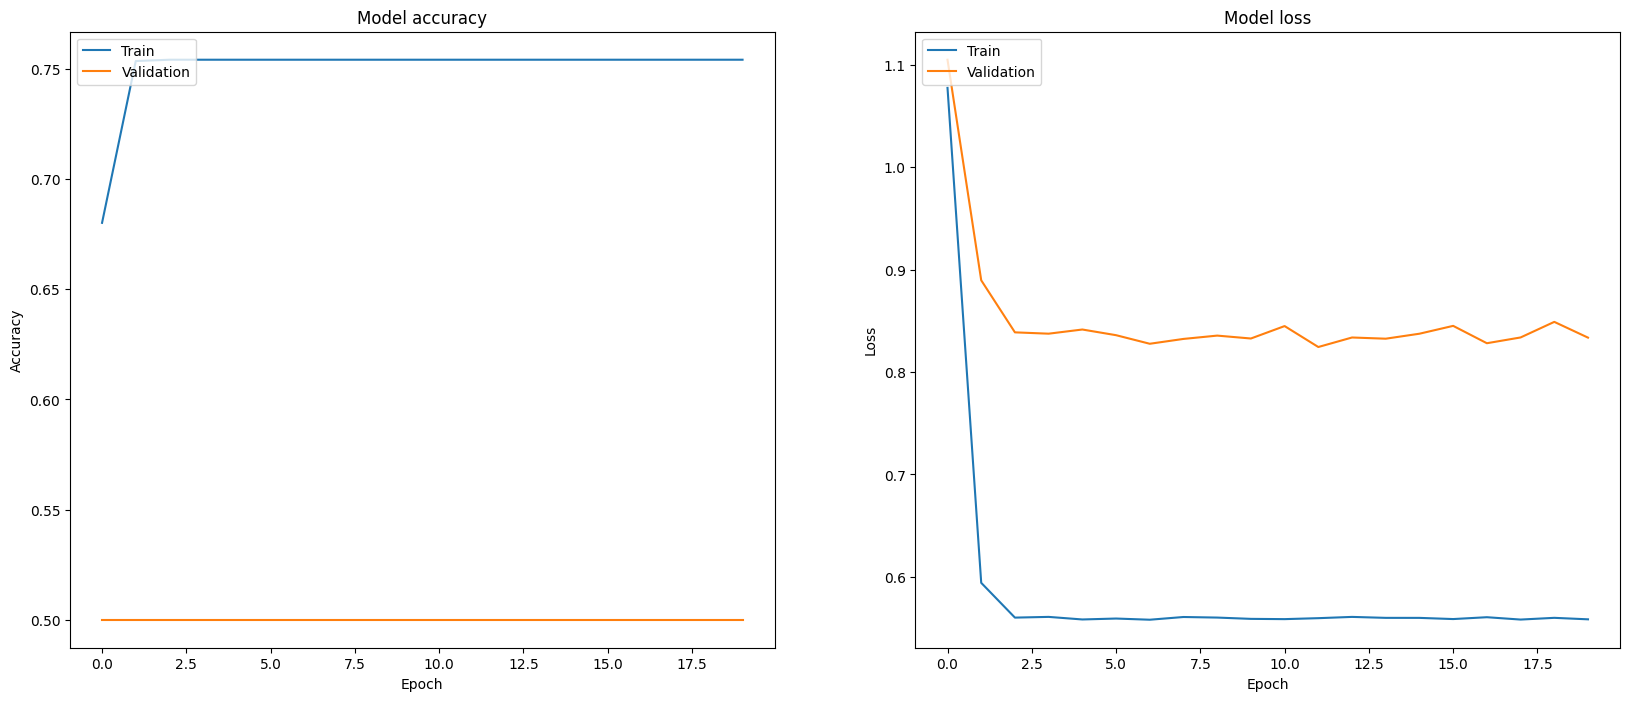

In [209]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Plot training & validation accuracy values
axes[0].plot(history_perm.history['accuracy'])
axes[0].plot(history_perm.history['val_accuracy'])
axes[0].set_title('Model accuracy')  # Fixed: Use set_title instead of title
axes[0].set_xlabel('Epoch')  # Fixed: Use set_xlabel instead of xlabel
axes[0].set_ylabel('Accuracy')  # Fixed: Use set_ylabel instead of ylabel
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history_perm.history['loss'])  # Fixed: Use axes[1] for the second subplot
axes[1].plot(history_perm.history['val_loss'])  # Fixed: Use axes[1] for the second subplot
axes[1].set_title('Model loss')  # Fixed: Use set_title instead of title
axes[1].set_xlabel('Epoch')  # Fixed: Use set_xlabel instead of xlabel
axes[1].set_ylabel('Loss')  # Fixed: Use set_ylabel instead of ylabel
axes[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [210]:
test_loss_permuted, test_accuracy_permuted = model_permuted.evaluate(test_generator)

print("Test Loss:", test_loss_permuted)
print("Test Accuracy:", test_accuracy_permuted)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.6223 - loss: 0.7041
Test Loss: 0.7010708451271057
Test Accuracy: 0.625


In [261]:
from tqdm import tqdm

predictions = []
true_labels = []

for images, labels in tqdm(test_generator):
   predictions.append(np.array(model_permuted.predict(images, verbose=False) > 0.5, dtype=int))
   true_labels.append(labels)

   if len(predictions) == len(test_generator):
       break

predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)

 95%|█████████▌| 19/20 [00:06<00:00,  2.74it/s]


In [263]:
balanced_accuracy = balanced_accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print("Balanced Accuracy:", balanced_accuracy)
print("F1 Score:", f1)

Balanced Accuracy: 0.5
F1 Score: 0.7692307692307693


In [260]:
np.unique(predictions)

array([1])

We see that the model only predicts two unique values for the output, which both round up to a predicted label of 1. This means that the permuted model predicts that everyone in the dataset has pneumonia, as it benefits if since pneumonia patients are the majority of the data points. This shows that the permuted model does not seem to find any pattern in the data.

In [317]:
images, labels = test_generator[0]

for i, (image, label_index) in enumerate(zip(images, labels)):
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    baseline_tensor = tf.zeros(image_tensor.shape)
    attribution_mask = integrated_gradients(image_tensor, int(label_index), baseline_tensor, model_permuted)
    attribution_mask = normalize_image(attribution_mask)
    label = "Normal" if label_index == 0 else "Pneumonia"
    prediction = model_permuted(tf.expand_dims(image, axis=0))
    predicted_label = "Normal" if prediction <= 0.5 else "Pneumonia"
    plot_img_attributions(baseline_tensor, image_tensor, attribution_mask, label, predicted_label, alpha=alpha, dir_path=f'figures/pt2/integrated_gradients_permuted/{label}', file_name=f'ig_{i}')

In [318]:
alpha = 0.5
images, labels = test_generator[0]

for i, (image, label_index) in enumerate(zip(images, labels)):
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

    gradcam = grad_cam(model_permuted, "last_conv_layer", image_tensor)
    label = "Normal" if label_index == 0 else "Pneumonia"
    prediction = model_permuted(tf.expand_dims(image, axis=0))
    predicted_label = "Normal" if prediction <= 0.5 else "Pneumonia"
    plot_gradcam(image, gradcam, label, predicted_label, alpha, 'figures/pt2/gradcam_permuted', f'gradcam_{i}')